In [25]:
import numpy as np
import random
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd
import matplotlib.pyplot as plt
import cufflinks
import plotly as py  
import plotly.tools as tls   
from plotly.graph_objs import *
import seaborn as sns
import scipy.optimize as sco
import yfinance as yf
import yahoo_fin.stock_info as si

In [2]:
np.random.seed(100)

In [51]:
tickers_list = ["OXY",'C', 'ICE',"NVDA","AAPL","TSLA","XOM","QCOM","GOOGL","AAP","BA"]

In [52]:
data = yf.download(tickers_list,'2018-1-1')['Adj Close']

[*********************100%***********************]  11 of 11 completed


In [53]:
return_list=((data.pct_change()+1).cumprod())
return_list

,AAP,AAPL,BA,C,GOOGL,ICE,NVDA,OXY,QCOM,TSLA,XOM
Date,,,,,,,,,,,
2018-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,1.009049,0.999826,1.003234,1.003093,1.017061,1.015175,1.065814,1.013787,1.011350,0.989767,1.019640
2018-01-04,1.046281,1.004470,0.999427,1.015465,1.021012,1.034359,1.071432,1.013247,1.012730,0.981562,1.021051
2018-01-05,1.057404,1.015907,1.040426,1.014121,1.034551,1.042949,1.080511,1.007704,1.019479,0.987677,1.020228
2018-01-08,1.049958,1.012133,1.044839,1.002286,1.038203,1.046815,1.113619,1.016356,1.016411,1.049543,1.024815
...,...,...,...,...,...,...,...,...,...,...,...
2023-02-07,1.518734,3.776511,0.759174,0.814049,2.005945,1.667991,4.494405,1.014697,2.410470,9.210214,1.757749
2023-02-08,1.492164,3.709846,0.754720,0.814368,1.851828,1.666465,4.500891,1.004173,2.331785,9.419866,1.742454
2023-02-09,1.523146,3.684205,0.749382,0.795740,1.770576,1.640382,4.527647,0.992706,2.302852,9.702056,1.749031


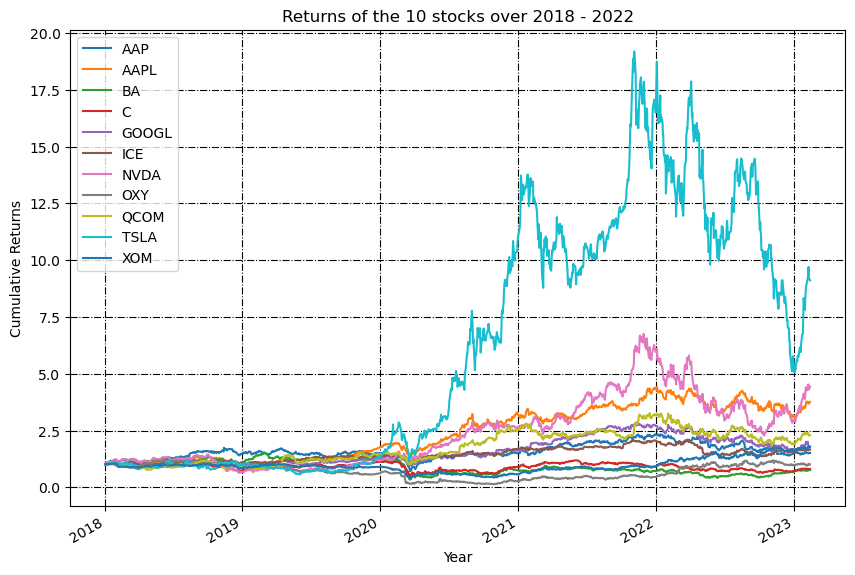

In [54]:
return_list.plot(figsize=(10, 7))
plt.legend()

plt.title("Returns of the 10 stocks over 2018 - 2022")
plt.ylabel('Cumulative Returns')
plt.xlabel('Year')
plt.grid(which="major", color='k', linestyle='-.')
plt.show()

Text(0, 0.5, 'daily returns')

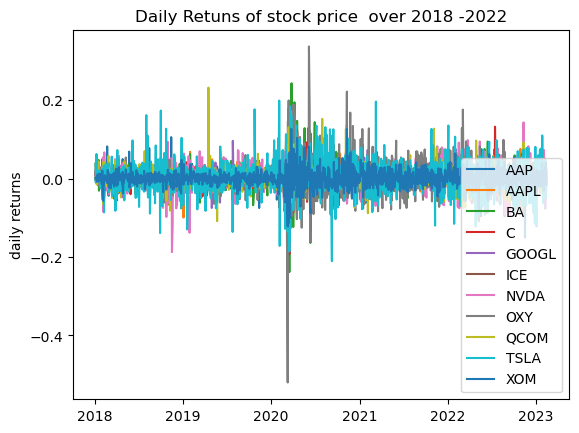

In [55]:
returns = return_list.pct_change()
for c in returns.columns.values:
    plt.plot(returns.index, returns[c],label=c)
plt.legend()
plt.title("Daily Retuns of stock price  over 2018 -2022")
plt.ylabel('daily returns')

In [56]:
returns = return_list.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 50000
risk_free_rate = 0.035

In [57]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

In [58]:
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate,num_asset):
    results = np.zeros((num_asset-1,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(num_asset)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [59]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

In [60]:
def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

In [61]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [62]:
def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [63]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [64]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

In [65]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [66]:
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate,len(mean_returns))
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=return_list.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=return_list.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", rp)
    print ("Annualised Volatility:", sdp)
    print ("\n")
    print (max_sharpe_allocation)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", rp_min)
    print ("Annualised Volatility:", sdp_min)
    print ("\n")
    print (min_vol_allocation)
    
    plt.scatter(results[0,:],results[1,:],color='b', marker='o')
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.32, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Distribution of return and risk and EF')
    plt.xlabel('volatility')
    plt.ylabel('returns (annual)')
    plt.legend(labelspacing=0.8)

In [67]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=return_list.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=return_list.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252

    fig, ax = plt.subplots()
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(return_list.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.34, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization')
    ax.set_xlabel('Volatility')
    ax.set_ylabel('Returns')
    ax.legend()

Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.4328363213531327
Annualised Volatility: 0.3804542258174031


            AAP   AAPL   BA    C  GOOGL  ICE  NVDA  OXY  QCOM   TSLA   XOM
allocation  0.0  47.76  0.0  0.0    0.0  0.0  6.22  0.0   0.0  37.01  9.02
Minimum Volatility Portfolio Allocation

Annualised Return: 0.15120553544312282
Annualised Volatility: 0.2225103490107536


              AAP  AAPL   BA    C  GOOGL    ICE  NVDA  OXY  QCOM  TSLA    XOM
allocation  16.56  5.78  0.0  0.0   9.96  49.32   0.0  0.0   0.0   0.0  18.37


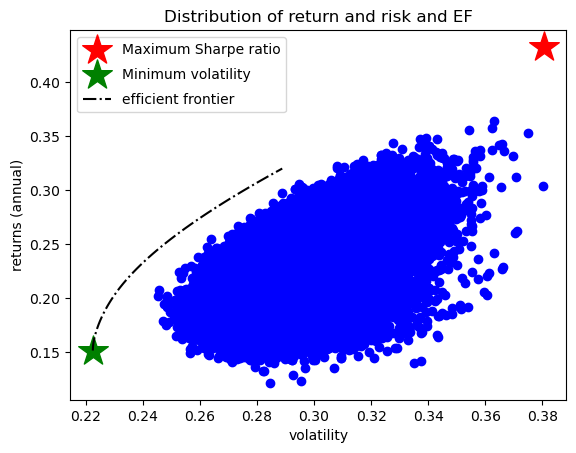

In [68]:
display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

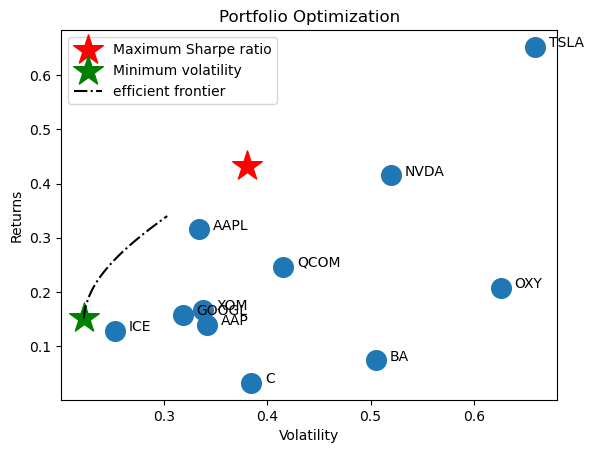

In [69]:
display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)

<h1> Now, start the real work. We will try to do the random sampling first

In [6]:
# First determine the number of random samples and the size
num_samples=10
samples_size=20

In [14]:
# Randomly pick n stocks from S&P_500
SP500_list = si.tickers_sp500()
SP500_list

['A',
 'AAL',
 'AAP',
 'AAPL',
 'ABBV',
 'ABC',
 'ABT',
 'ACGL',
 'ACN',
 'ADBE',
 'ADI',
 'ADM',
 'ADP',
 'ADSK',
 'AEE',
 'AEP',
 'AES',
 'AFL',
 'AIG',
 'AIZ',
 'AJG',
 'AKAM',
 'ALB',
 'ALGN',
 'ALK',
 'ALL',
 'ALLE',
 'AMAT',
 'AMCR',
 'AMD',
 'AME',
 'AMGN',
 'AMP',
 'AMT',
 'AMZN',
 'ANET',
 'ANSS',
 'AON',
 'AOS',
 'APA',
 'APD',
 'APH',
 'APTV',
 'ARE',
 'ATO',
 'ATVI',
 'AVB',
 'AVGO',
 'AVY',
 'AWK',
 'AXP',
 'AZO',
 'BA',
 'BAC',
 'BALL',
 'BAX',
 'BBWI',
 'BBY',
 'BDX',
 'BEN',
 'BF-B',
 'BIIB',
 'BIO',
 'BK',
 'BKNG',
 'BKR',
 'BLK',
 'BMY',
 'BR',
 'BRK-B',
 'BRO',
 'BSX',
 'BWA',
 'BXP',
 'C',
 'CAG',
 'CAH',
 'CARR',
 'CAT',
 'CB',
 'CBOE',
 'CBRE',
 'CCI',
 'CCL',
 'CDAY',
 'CDNS',
 'CDW',
 'CE',
 'CEG',
 'CF',
 'CFG',
 'CHD',
 'CHRW',
 'CHTR',
 'CI',
 'CINF',
 'CL',
 'CLX',
 'CMA',
 'CMCSA',
 'CME',
 'CMG',
 'CMI',
 'CMS',
 'CNC',
 'CNP',
 'COF',
 'COO',
 'COP',
 'COST',
 'CPB',
 'CPRT',
 'CPT',
 'CRL',
 'CRM',
 'CSCO',
 'CSGP',
 'CSX',
 'CTAS',
 'CTLT',
 'CTRA',
 'C

In [49]:
sample_list=np.zeros((1,samples_size))
for i in range(num_samples):
    stock_array=np.array([])
    for j in range(samples_size):
        random_index=int(random.randint(0,500))
        while np.isin(SP500_list[random_index],stock_array):
            random_index=int(random.randint(0,500))
        stock_array =np.append(stock_array,SP500_list[random_index])
    sample_list=np.append(sample_list,[stock_array],axis=0)
sample_list=sample_list[1:,:]

In [50]:
sample_list

array([['NEM', 'WMT', 'PEG', 'V', 'XRAY', 'OTIS', 'AAP', 'WY', 'CSGP',
        'AMP', 'FOX', 'DAL', 'INTC', 'KLAC', 'MSCI', 'CDAY', 'CE', 'PG',
        'SLB', 'AMD'],
       ['IR', 'XEL', 'WTW', 'NWS', 'CLX', 'CINF', 'TPR', 'INCY', 'LEN',
        'NDSN', 'SNPS', 'BEN', 'JBHT', 'BIO', 'JNJ', 'FLT', 'STT', 'PCG',
        'ACGL', 'XOM'],
       ['AMT', 'CBRE', 'AVY', 'ROL', 'CTVA', 'RSG', 'TGT', 'DLR', 'GE',
        'WEC', 'MCK', 'CZR', 'NFLX', 'AMZN', 'NVR', 'MPC', 'UNP', 'DVN',
        'PEAK', 'EIX'],
       ['NDSN', 'FIS', 'WDC', 'DOW', 'FTV', 'TRV', 'HLT', 'CSX', 'AME',
        'MRK', 'CAH', 'WHR', 'BK', 'WM', 'ZBRA', 'PEAK', 'CL', 'LYB',
        'COO', 'CTLT'],
       ['NWS', 'XRAY', 'SWK', 'ON', 'OXY', 'WM', 'EVRG', 'CBOE', 'FRT',
        'ADI', 'CMI', 'TDG', 'EL', 'WTW', 'AEP', 'BWA', 'VICI', 'COP',
        'FFIV', 'GILD'],
       ['WMB', 'DOW', 'LNT', 'HAS', 'NUE', 'MDLZ', 'MNST', 'IRM', 'PAYX',
        'PEAK', 'KO', 'LUMN', 'MOS', 'AMP', 'AIZ', 'RMD', 'COP', 'OXY',
        'FLT',

In [20]:
stock_array,si.get_data(SP500_list[random_index], start_date="01/01/2020",end_date="06/01/2022", index_as_date = False, interval="1d")['adjclose'].values

array([ 84.24536896,  82.8927536 ,  83.13778687,  83.39263153,
        84.21598053,  85.53920746,  85.85285187,  85.72543335,
        86.24493408,  86.86243439,  87.68577576,  88.33267975,
        87.83279419,  88.34249115,  87.30349731,  86.50956726,
        84.84328461,  85.45098877,  85.50980377,  82.70651245,
        80.92260742,  80.52075195,  81.86356354,  83.2456131 ,
        83.13778687,  81.52052307,  82.75553894,  83.4024353 ,
        83.73570251,  83.77490997,  84.11794281,  83.10838318,
        83.6572876 ,  82.66731262,  83.38283539,  78.90348053,
        76.4040451 ,  76.56086731,  75.89437103,  75.54149628,
        80.34431458,  78.72705078,  82.67711639,  78.86426544,
        77.00195312,  69.3468399 ,  71.46400452,  67.47471619,
        62.16221237,  67.82757568,  62.85812378,  69.04299927,
        67.5041275 ,  64.45579529,  65.141922  ,  62.11320496,
        65.67120361,  67.63154602,  72.25792694,  69.50367737,
        71.41003418,  70.37824249,  67.72504425,  71.03